In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import yellowbrick as yb

from yellowbrick.features import RadViz
from sklearn.metrics import accuracy_score
from yellowbrick.features import Rank2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.features import FeatureImportances
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def connectDB(DB):
    # connect to the PostgreSQL server
    return psycopg2.connect(
        database=DB,
        user="postgres",
        password="Georgetown16",
        host="database-1.c5vispb5ezxg.us-east-1.rds.amazonaws.com",
        port='5432')

def disconnectDB():
    cur.close()
    conn.close()

In [3]:
conn = connectDB("Dataset")

# extract everything from 'table_name' into a dataframe
df = pd_sql.read_sql(f"select * from public.\"featureSTG\" ", con=conn)
#code to be able to view all the columns in pandas dataframe
pd.set_option('display.max_columns', 50) 
              

# Feature Analysis

In [4]:
df = df[['code_module', 'module_domain', 'module_presentation_length','year','term', 'num_of_prev_attempts',
                    'final_result', 'date_registration', 'disability', 'gender', 'age_band', 'region', 'highest_education', 
                    'imd_band', 'studied_credits', 'b4_sum_clicks', 'half_sum_clicks', 'std_half_score']]

In [5]:
feature_list = df

In [6]:
feature_list = df.loc[(df.year == 0)&(df.module_domain==0)]

In [7]:
#feature_list = feature_list.drop(['level_0', 'index', 'id_student',])]

#remove null values
feature_list = feature_list.dropna()

In [8]:
#save dataset to desktop in CSV
#df_temp.to_csv('dataset_not_mapped.csv')

In [9]:
feature_list.head()

,code_module,module_domain,module_presentation_length,year,term,num_of_prev_attempts,final_result,date_registration,disability,gender,age_band,region,highest_education,imd_band,studied_credits,b4_sum_clicks,half_sum_clicks,std_half_score
4,0,0,268,0,0,0,1,-159.0,0,0,2,1,3,9.0,240,98.0,612.0,81.600000
5,1,0,240,0,1,2,0,-47.0,0,1,0,1,1,2.0,60,14.0,147.0,38.813953
8,1,0,268,0,0,0,1,-27.0,0,0,0,9,2,5.0,60,6.0,365.0,89.612903
12,6,0,261,0,0,0,1,-64.0,0,0,0,7,2,8.0,30,0.0,263.0,0.000000
14,1,0,240,0,1,0,1,-73.0,0,1,0,1,1,2.0,120,5.0,1465.0,63.000000


In [10]:
feature_list = feature_list[feature_list.columns.drop(['module_domain', 'year', 'term'])]

In [11]:
feature_list.to_csv('feature_list.csv')

# Feature Selection

In [12]:
X = feature_list[["half_sum_clicks","gender","highest_education", "code_module", "studied_credits"]].values
        
y = feature_list["final_result"].values

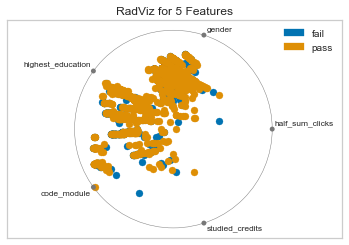

In [13]:
classes = ["fail", "pass"]
features = ["half_sum_clicks", "gender", "highest_education", "code_module", "studied_credits"]
        
sns.set_palette("colorblind")
# Instantiate the visualizer
visualizer = RadViz (
    classes=classes,
    features = features
)

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


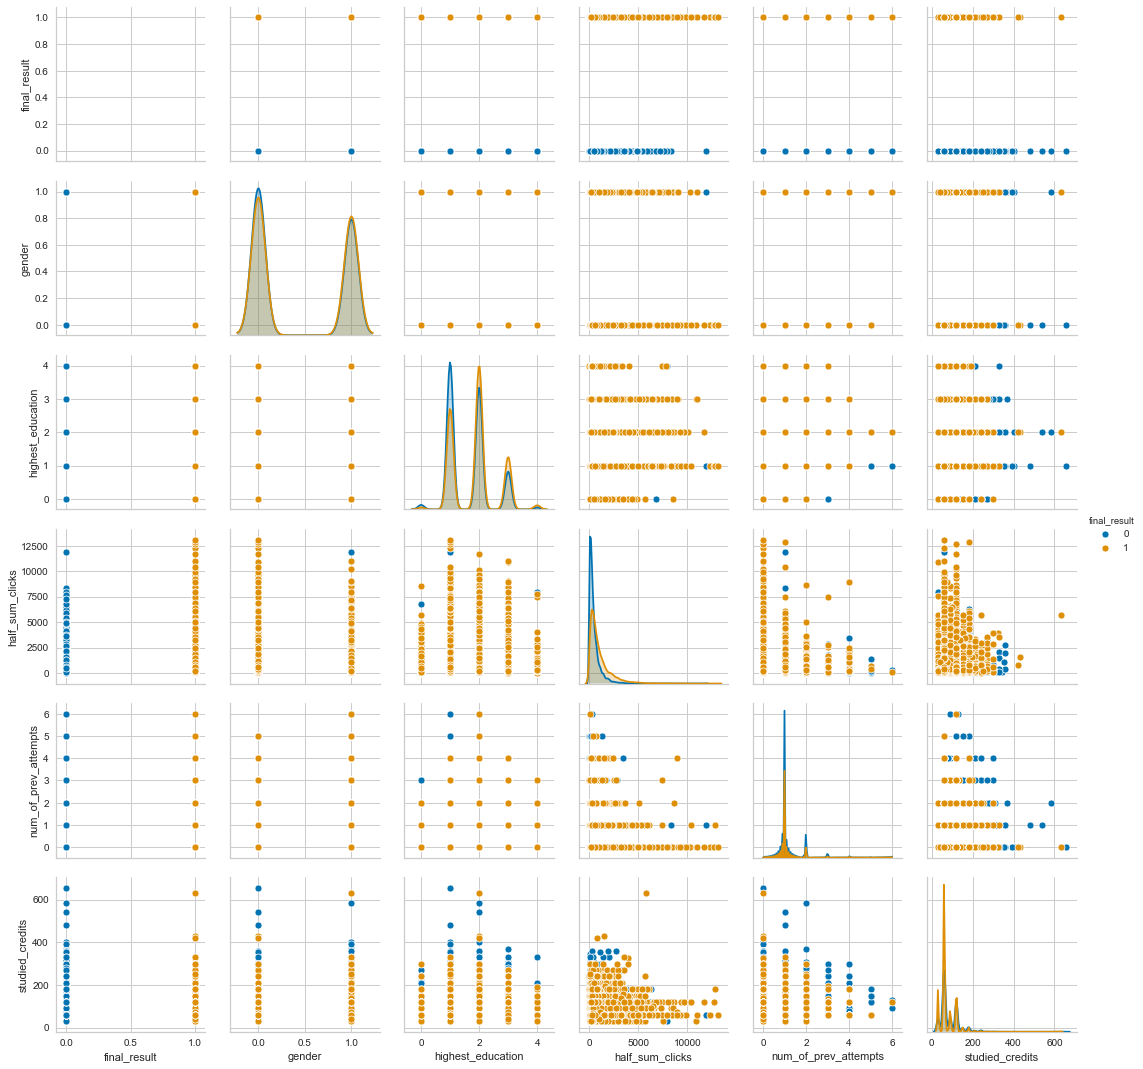

In [14]:
df_plot = df[["final_result","gender", "highest_education", "half_sum_clicks","num_of_prev_attempts", "studied_credits"]]
g = sns.pairplot(df_plot, hue="final_result")
plt.show()

In [15]:
y

array([1, 0, 1, ..., 1, 1, 1])

In [16]:

#accuracy_score(test_y, predictions)

In [17]:
#check status of data
feature_list.head()

,code_module,module_presentation_length,num_of_prev_attempts,final_result,date_registration,disability,gender,age_band,region,highest_education,imd_band,studied_credits,b4_sum_clicks,half_sum_clicks,std_half_score
4,0,268,0,1,-159.0,0,0,2,1,3,9.0,240,98.0,612.0,81.600000
5,1,240,2,0,-47.0,0,1,0,1,1,2.0,60,14.0,147.0,38.813953
8,1,268,0,1,-27.0,0,0,0,9,2,5.0,60,6.0,365.0,89.612903
12,6,261,0,1,-64.0,0,0,0,7,2,8.0,30,0.0,263.0,0.000000
14,1,240,0,1,-73.0,0,1,0,1,1,2.0,120,5.0,1465.0,63.000000


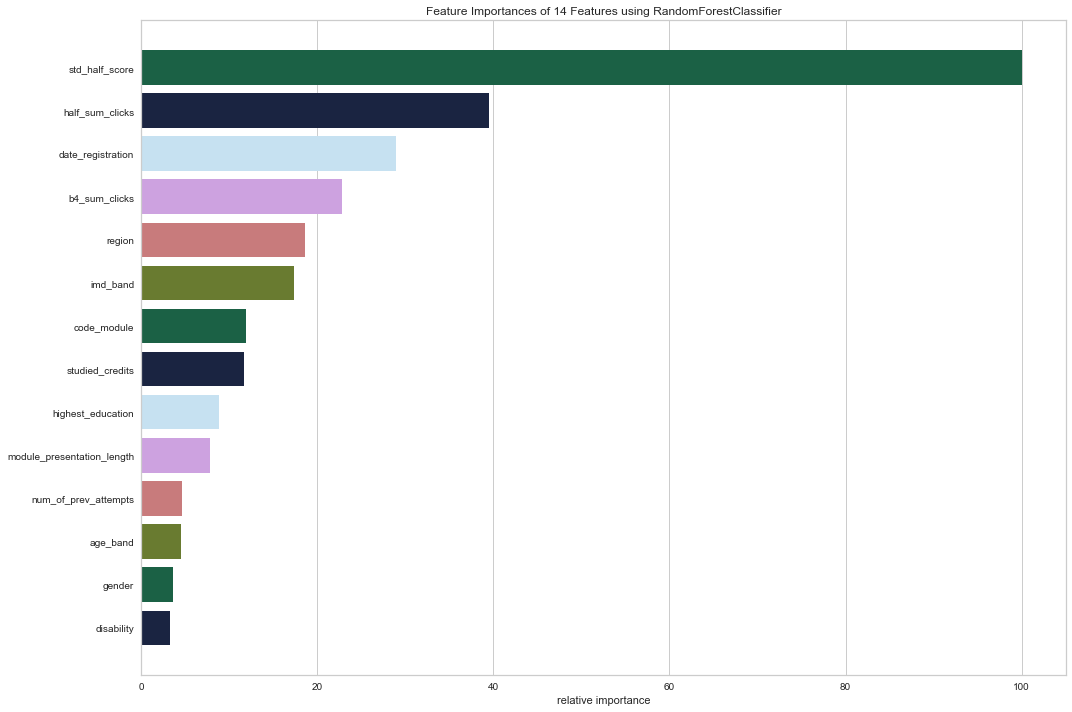

In [18]:
sns.set_palette("cubehelix")

X = feature_list[feature_list.columns.drop(['final_result'])]

y = feature_list['final_result']

model = RandomForestClassifier(n_estimators=10)
feature_list = FeatureImportances(model, size=(1080, 720))
feature_list.fit(X, y)

feature_list.show()

//anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


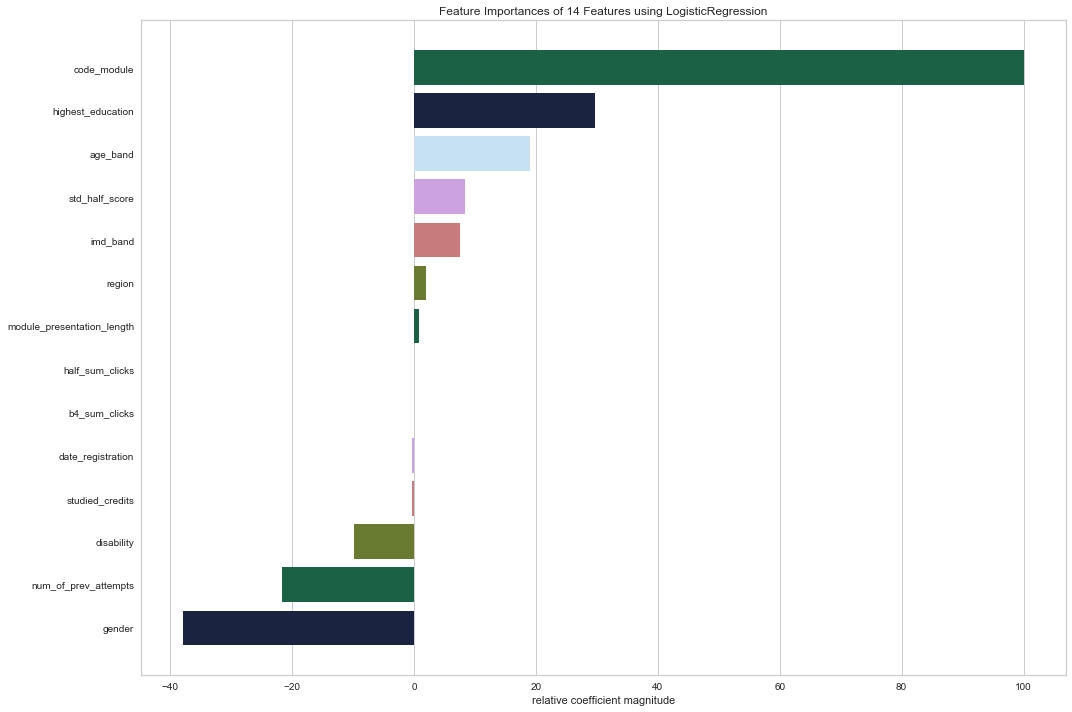

In [19]:
model = LogisticRegression()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)

viz.show()

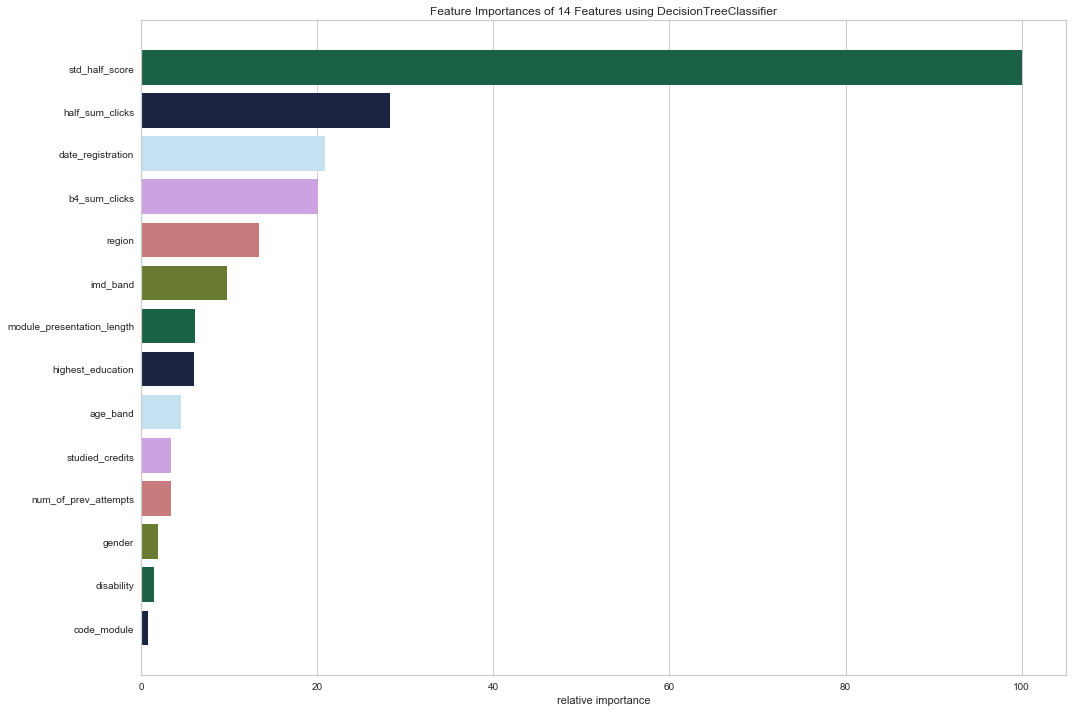

In [20]:
model = DecisionTreeClassifier()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
viz.show()

In [21]:
feature_list = RandomForestClassifier()
feature_list.fit(X, y)
predictions = feature_list.predict(X)
    
accuracy_score(y, predictions)

0.9904099736274274

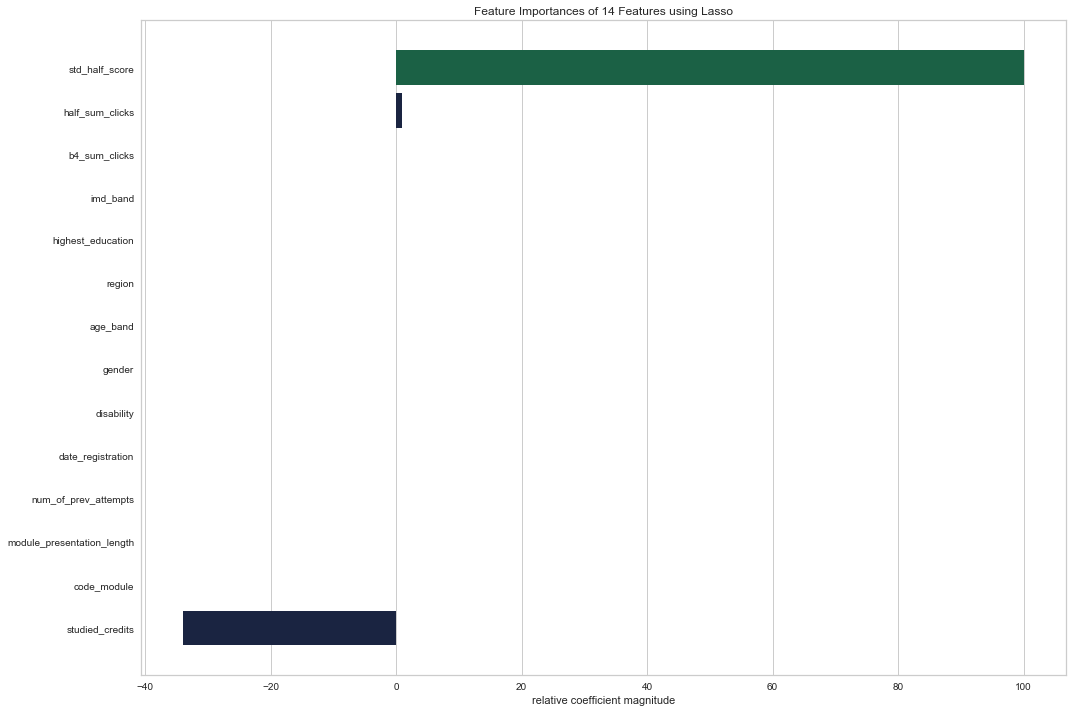

In [22]:
model = Lasso()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
viz.show()


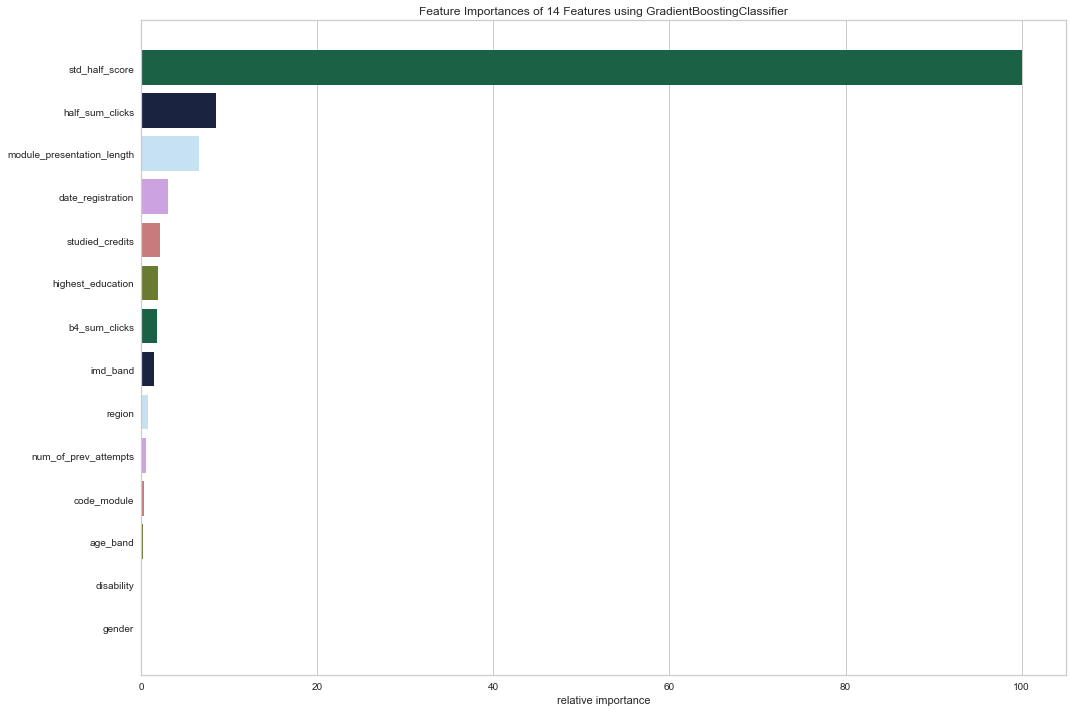

In [23]:
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier()
viz = FeatureImportances(model, size=(1080, 720))
viz.fit(X, y)
viz.show()

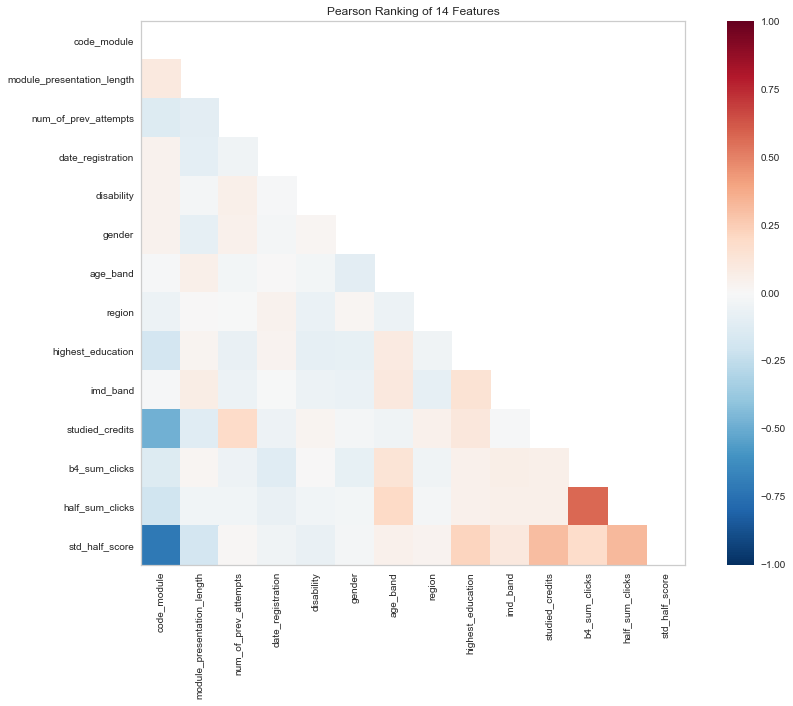

In [24]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

In [25]:
#features = feature_list[feature_list.columns.drop(['final_result'])]
#label = feature_list['final_result']

//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
//anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


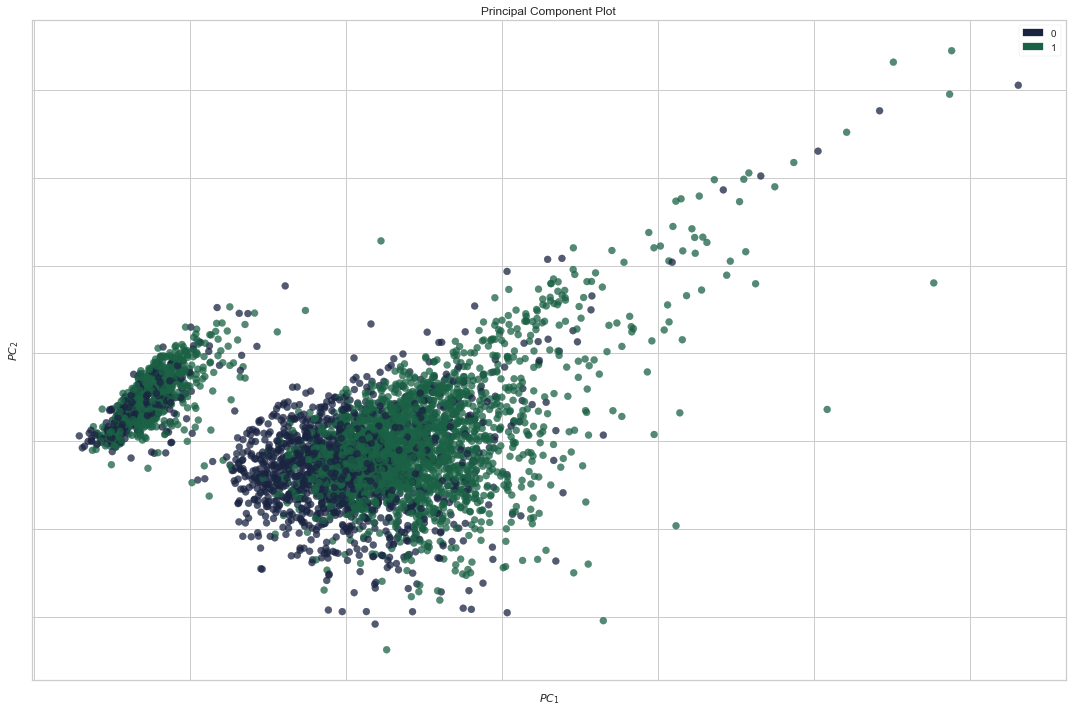

In [26]:
from yellowbrick.features.pca import PCADecomposition

# Create a list of colors to assign to points in the plot
colors = np.array(['r' if yi else 'b' for yi in y])

visualizer = PCADecomposition(
    scale=True, color=colors, size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X, y)
visualizer.show()

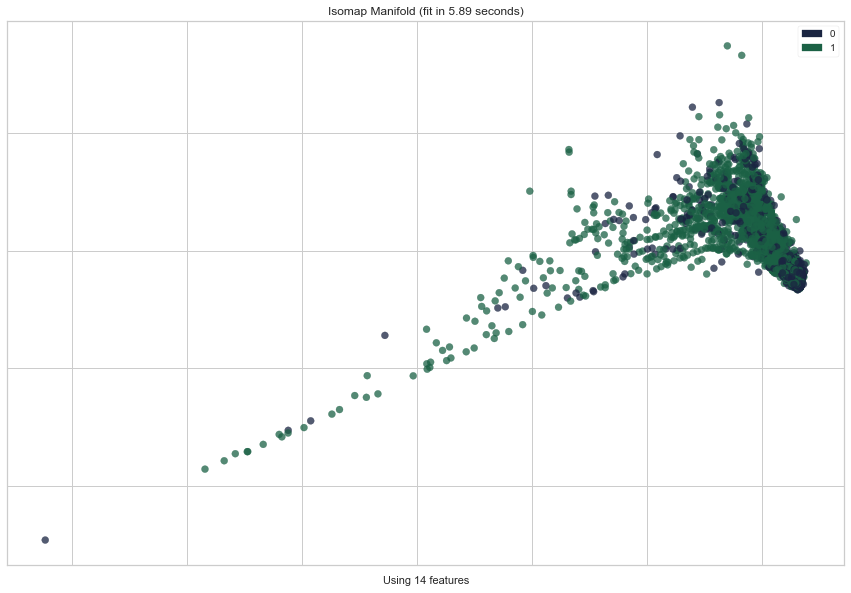

In [27]:
from yellowbrick.features.manifold import Manifold

visualizer = Manifold(
    manifold='isomap', n_neighbors=5, target='continuous', size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X, y)
visualizer.show()

# Regularization Techniques

In [28]:
features = X
labels   = y

In [29]:
list(features)

['code_module',
 'module_presentation_length',
 'num_of_prev_attempts',
 'date_registration',
 'disability',
 'gender',
 'age_band',
 'region',
 'highest_education',
 'imd_band',
 'studied_credits',
 'b4_sum_clicks',
 'half_sum_clicks',
 'std_half_score']

In [30]:
model = LinearRegression()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', 0.15438245469351167), ('module_presentation_length', 0.005769413851882925), ('num_of_prev_attempts', -0.013146621341542411), ('date_registration', -0.00033267206908865976), ('disability', -0.006344069512541645), ('gender', -0.02362695194352756), ('age_band', 0.025194867836454936), ('region', 0.0028180958904288587), ('highest_education', 0.041416042750324726), ('imd_band', 0.009250039381885478), ('studied_credits', -5.948136602974336e-05), ('b4_sum_clicks', -5.893466075908085e-05), ('half_sum_clicks', 1.8509645836924625e-05), ('std_half_score', 0.012082609590661583)]


In [31]:
model = Lasso()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', 0.0), ('module_presentation_length', 0.0), ('num_of_prev_attempts', -0.0), ('date_registration', -0.0), ('disability', -0.0), ('gender', -0.0), ('age_band', 0.0), ('region', -0.0), ('highest_education', 0.0), ('imd_band', 0.0), ('studied_credits', -0.0015303967074833424), ('b4_sum_clicks', -0.0), ('half_sum_clicks', 4.352835953446355e-05), ('std_half_score', 0.004515489993660068)]


In [32]:
model = Ridge()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', 0.15436014683995525), ('module_presentation_length', 0.00576944225618787), ('num_of_prev_attempts', -0.013143130770843), ('date_registration', -0.0003326356451490111), ('disability', -0.0063304637220476054), ('gender', -0.023587486524514364), ('age_band', 0.025173993204325073), ('region', 0.0028175416386520703), ('highest_education', 0.041396531652833427), ('imd_band', 0.009251830641646685), ('studied_credits', -5.980816905036663e-05), ('b4_sum_clicks', -5.89216134184718e-05), ('half_sum_clicks', 1.8512678797632966e-05), ('std_half_score', 0.012081820337678417)]


In [33]:
model = ElasticNet()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', 0.0), ('module_presentation_length', 0.0014697625344716728), ('num_of_prev_attempts', -0.0), ('date_registration', -0.00010082541310577098), ('disability', -0.0), ('gender', -0.0), ('age_band', 0.0), ('region', -0.0), ('highest_education', 0.0), ('imd_band', 0.0), ('studied_credits', -0.001980841912136664), ('b4_sum_clicks', -0.0), ('half_sum_clicks', 3.5644530647510836e-05), ('std_half_score', 0.005311053752838566)]


In [34]:
model = LogisticRegression()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', [0.8798188451892556, 0.01200488430898518, -0.16427671540594904, -0.002430538375351914, -0.0776983079324461, -0.27994960810929803, 0.16446032172404074, 0.017406110213021568, 0.2666679941079602, 0.06515065949338787, -0.0023192392468449493, -0.00047299434342078743, 0.00020755353188363826, 0.07337310898250977])]


# Transformer Techniques

In [35]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['studied_credits', 'half_sum_clicks', 'std_half_score']


In [36]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['code_module', 'gender', 'age_band', 'highest_education']


In [37]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['module_presentation_length', 'studied_credits', 'std_half_score']


# Model Evaluation

In [38]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

In [39]:
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]

In [40]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder(categories = 'auto')),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

for model in models:
    score_model(X, y, model)

SVC: 0.7867946480511925
NuSVC: 0.9557168784029039
LinearSVC: 0.982963912804543
SGDClassifier: 0.9712944574833002
KNeighborsClassifier: 0.8150624670068626
LogisticRegression: 0.9172041136482482


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//ana

LogisticRegressionCV: 0.9643954455087655
BaggingClassifier: 0.9844903988183161
ExtraTreesClassifier: 1.0
RandomForestClassifier: 1.0
